# ORES -- Wikipedia ML as a service API
## Sample API code
This code is made available for re-use under a [CC0 license](https://creativecommons.org/share-your-work/public-domain/cc0/). 


In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys

import oresapi
import mwapi
import mwtypes

In [2]:
endpoint_ores = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}{features}'

In [3]:
example_params_damaging = {
                    "project" : "enwiki",
                    "revid" : "1049151926",
                    "model" : "damaging",
                    "features" : ""  #use "?features" to get all features used in scoring
                          }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/staeiou',
    'From': 'stuart@stuartgeiger.com'
}

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
example_ores_damaging = api_call(endpoint_ores, example_params_damaging)

In [6]:
example_ores_damaging

{'enwiki': {'models': {'damaging': {'version': '0.5.1'}},
  'scores': {'1049151926': {'damaging': {'score': {'prediction': False,
      'probability': {'false': 0.9586154188228114,
       'true': 0.04138458117718854}}}}}}}

This part of the code is from: https://github.com/halfak/ores-demos/blob/master/Article%20quality%20demo.ipynb

In [7]:
ores_session = oresapi.Session(
    "https://ores.wikimedia.org",
    user_agent="User:Staeiou -- ORES overview -- Article Quality")
list(ores_session.score('enwiki', ['articlequality'], 761065293))

[{'articlequality': {'score': {'prediction': 'FA',
    'probability': {'B': 0.03779869850962798,
     'C': 0.02044421174899556,
     'FA': 0.5984324889334588,
     'GA': 0.3334796157125206,
     'Start': 0.007067204099333244,
     'Stub': 0.0027777809960638834}}}}]

In [8]:
session = mwapi.Session(
    "https://en.wikipedia.org", 
    user_agent="User:Staeiou ORES queries")

In [9]:
def fetch_history(page_title):
    """
    Fetches all of the historical versions of a page based on its title. 
    """
    historical_versions = []
    for response_doc in session.get(action='query', prop='revisions', titles=page_title, 
                                    rvprop=['ids', 'timestamp'], rvlimit=100, rvdir="newer", 
                                    formatversion=2, continuation=True):
        rev_docs = response_doc['query']['pages'][0]['revisions']
        rev_ids = [d['revid'] for d in rev_docs]
        for rev_doc in rev_docs:
            rev_id = rev_doc['revid']
            timestamp = mwtypes.Timestamp(rev_doc['timestamp'])
            historical_versions.append({'rev_id': rev_id, 'timestamp': timestamp})
            sys.stderr.write("R")
            sys.stderr.flush()
        sys.stderr.write("\n")
    
    return historical_versions

In [10]:
WEIGHTS = {'Stub': 1, 'Start': 2, 'C': 3, 'B': 4, 'GA': 5, 'FA': 6}
def score2sum(score_doc):
    "Converts an output from ORES articlequality prediction into a single value between 1 and 6."
    if score_doc is None or 'probability' not in score_doc:
        return None
    weighted_sum = 0
    for cl, proba in score_doc['probability'].items():
        weighted_sum += WEIGHTS[cl] * proba
    return weighted_sum

In [11]:
def fetch_scores(revisions):
    """
    Fetches scores for all revisions provided and adds a "weighted_sum" field with the processed score.
    """
    scores = ores_session.score('enwiki', ['articlequality'], [r['rev_id'] for r in revisions])
    for score, revision in zip(scores, revisions):
        revision['weighted_sum'] = score2sum(score['articlequality']['score'])
        sys.stderr.write("S")
        sys.stderr.flush()
    sys.stderr.write("\n")
    
    return revisions

This will get all revisions to an article (each revision query prints a "R") and then scores each of those revisions with ORES's articlequality model (each ORES query prints a "S").

In [12]:
historical_scores = pd.DataFrame(fetch_scores(fetch_history("University of California, San Diego")))
historical_scores[:10]

RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR

,rev_id,timestamp,weighted_sum
0,382242594,2001-08-19T00:30:27Z,1.157552
1,111583,2002-02-25T15:51:15Z,1.164874
2,111585,2002-07-06T19:26:18Z,1.087927
3,673031,2002-07-06T19:27:04Z,1.087927
4,673033,2003-02-16T09:51:22Z,1.186121
5,673053,2003-02-16T09:54:55Z,1.139065
6,673058,2003-02-16T10:13:11Z,1.130027
7,673062,2003-02-16T10:17:54Z,1.133420
8,833211,2003-02-16T10:19:30Z,1.133420
9,833214,2003-04-15T15:38:33Z,1.154761


<AxesSubplot:xlabel='time'>

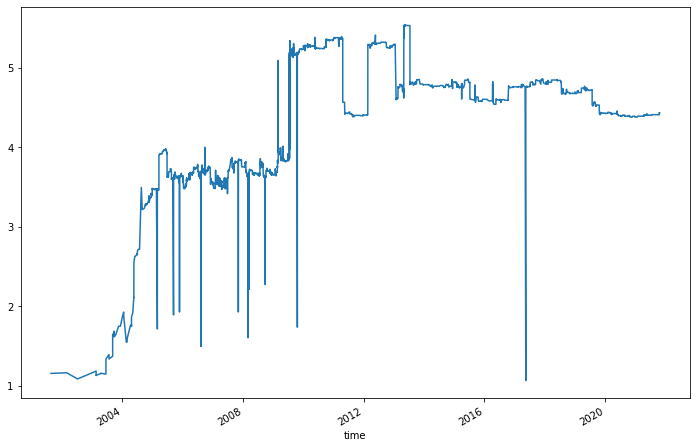

In [13]:
historical_scores['time'] = pd.to_datetime(historical_scores.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
historical_scores = historical_scores.set_index('time')
historical_scores['weighted_sum'].plot(figsize=(12,8))

### Feature injection

See https://www.mediawiki.org/wiki/ORES/Feature_injection

In [14]:
def api_post(endpoint,parameters,payload):
    print(endpoint.format(**parameters))
    call = requests.post(endpoint.format(**parameters),
                         headers=headers,
                         data=json.dumps(payload))
    
    response = call.json()
    
    return response

In [15]:
endpoint_ores = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}{features}'

In [16]:
features = {"feature.temporal.revision.user.seconds_since_registration":864010,
            "feature.revision.user.is_bot":"false"}

In [17]:
features_str = "?features"
for key, value in features.items():
    features_str += "&" + str(key) + "=" + str(value)
features_str

'?features&feature.temporal.revision.user.seconds_since_registration=864010&feature.revision.user.is_bot=false'

In [18]:
rev_id = 1049151926

example_params_ores_push = {
                    "project" : "enwiki",
                    "revid" : str(rev_id),
                    "model" : "damaging",
                    "features" : features_str
                          }

# Not a good idea to pass the entire page text via the URL...
# But injecting via POST payload isn't working for some reason.

payload = {"inject":
              {rev_id:
                  {"datasource.revision.text": None}
              }
          }

headers = {
    'User-Agent': 'https://github.com/staeiou',
    'From': 'stuart@stuartgeiger.com',
    'method': 'POST'
}

In [19]:
api_post(endpoint_ores, example_params_ores_push, None)

https://ores.wikimedia.org/v3/scores/enwiki/1049151926/damaging?features&feature.temporal.revision.user.seconds_since_registration=864010&feature.revision.user.is_bot=false


{'enwiki': {'models': {'damaging': {'version': '0.5.1'}},
  'scores': {'1049151926': {'damaging': {'features': {'feature.english.badwords.revision.diff.match_delta_decrease': 0,
      'feature.english.badwords.revision.diff.match_delta_increase': 0,
      'feature.english.badwords.revision.diff.match_delta_sum': 0,
      'feature.english.badwords.revision.diff.match_prop_delta_decrease': 0.0,
      'feature.english.badwords.revision.diff.match_prop_delta_increase': 0.0,
      'feature.english.badwords.revision.diff.match_prop_delta_sum': 0.0,
      'feature.english.dictionary.revision.diff.dict_word_delta_decrease': -2,
      'feature.english.dictionary.revision.diff.dict_word_delta_increase': 0,
      'feature.english.dictionary.revision.diff.dict_word_delta_sum': -2,
      'feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease': -0.3436426116838488,
      'feature.english.dictionary.revision.diff.dict_word_prop_delta_increase': 0.0,
      'feature.english.dictionary.

### Auditing how account age (time after registration) impacts scores

In [20]:
weeks_in_seconds = []
for week in range(0,60):
    weeks_in_seconds.append(week*60*60*24*7)

In [21]:
weeks_in_seconds[:5]

[0, 604800, 1209600, 1814400, 2419200]

We will examine this revision: https://en.wikipedia.org/w/index.php?title=Australian_Electoral_Commission&diff=prev&oldid=1051883627

In [22]:
results = []
for interval in weeks_in_seconds:
    
    features = {"feature.temporal.revision.user.seconds_since_registration":interval,
            "feature.revision.user.is_bot":"false"}
    
    features_str = "?features"
    for key, value in features.items():
        features_str += "&" + str(key) + "=" + str(value)
    features_str
    
    rev_id = 1051883627

    example_params_ores_push = {
                    "project" : "enwiki",
                    "revid" : str(rev_id),
                    "model" : "damaging",
                    "features" : features_str
                          }

    headers = {
        'User-Agent': 'https://github.com/staeiou',
        'From': 'stuart@stuartgeiger.com',
        'method': 'POST'
    }
    
    result = api_post(endpoint_ores, example_params_ores_push, payload)
    
    score = {'week':str(interval/(60*60*24)),
             'prob_damaging':result['enwiki']['scores'][str(rev_id)]['damaging']['score']['probability']['true']}
    
    
    results.append(score)

https://ores.wikimedia.org/v3/scores/enwiki/1051883627/damaging?features&feature.temporal.revision.user.seconds_since_registration=0&feature.revision.user.is_bot=false
https://ores.wikimedia.org/v3/scores/enwiki/1051883627/damaging?features&feature.temporal.revision.user.seconds_since_registration=604800&feature.revision.user.is_bot=false
https://ores.wikimedia.org/v3/scores/enwiki/1051883627/damaging?features&feature.temporal.revision.user.seconds_since_registration=1209600&feature.revision.user.is_bot=false
https://ores.wikimedia.org/v3/scores/enwiki/1051883627/damaging?features&feature.temporal.revision.user.seconds_since_registration=1814400&feature.revision.user.is_bot=false
https://ores.wikimedia.org/v3/scores/enwiki/1051883627/damaging?features&feature.temporal.revision.user.seconds_since_registration=2419200&feature.revision.user.is_bot=false
https://ores.wikimedia.org/v3/scores/enwiki/1051883627/damaging?features&feature.temporal.revision.user.seconds_since_registration=302400

In [23]:
results_df  = pd.DataFrame(results)
results_df[:5]

,week,prob_damaging
0,0.0,0.963998
1,7.0,0.958551
2,14.0,0.953594
3,21.0,0.951448
4,28.0,0.943959


Text(0, 0.5, 'Predicted probability of damage')

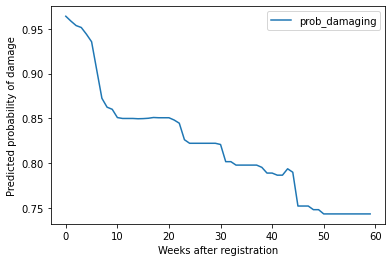

In [24]:
fig = results_df.plot(kind='line')
fig.set_xlabel("Weeks after registration")
fig.set_ylabel("Predicted probability of damage")

### Getting page text from the API

In [25]:
endpoint_page_text = "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&titles={pagetitle}&formatversion=2&rvprop=content&rvslots=*&rvstartid={revid}&rvendid={revid}"

In [26]:
example_params_page_text = {
                    "pagetitle" : "Juba",
                    "revid" : "1049151926"
                          }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/staeiou',
    'From': 'stuart@stuartgeiger.com'
}

In [27]:
example_page_text = api_call(endpoint_page_text, example_params_page_text)

In [28]:
page_text = example_page_text['query']['pages'][0]['revisions'][0]['slots']['main']['content']

In [29]:
page_text

'{{short description|Capital and the largest city of South Sudan}}\n{{about|the capital of South Sudan}}\n{{Lead too short|date=September 2020}}\n\n{{Use dmy dates|date=November 2013}}\n{{Infobox settlement\n| settlement_type                 = Capital\n| official_name                   = Juba\n| nickname                        = \n| image_flag                      = Flag of Juba.gif\n| image_skyline                   = {{Photomontage|position=center\n|photo1a =JUBA VIEW.jpg\n|photo2a =John Garang Mausoleum Square in Juba.JPG\n|photo2b =Juba Sudan aerial view.jpg\n|photo3a =United Nations (UTair) Boeing 737-500-1.jpg\n|photo3b =Juba, capital de Sudan del Sud.jpg\n|photo4a =\n|photo4b =\n|size = 270\n|spacing = 1\n|color = #FFFFFF\n|border = 1\n}}\n| image_caption          = Photos of Juba\n| imagesize                       = 270px\n| image_seal                      = \n| image_map                       = \n| mapsize                         = \n| pushpin_map                     = South S